<a href="https://colab.research.google.com/github/coderacheal/Alkebulan/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
%pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
...,...,...,...
937849,@Juice_Lemons in the dark. it’s so good,en,positive
937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,en,negative
937852,@reblavoie So happy for her! She’s been incred...,en,positive


In [4]:
df.shape

(937854, 3)

In [5]:
df['Language'].unique()

array(['en', 'es', 'ca', 'fr', 'pt', 'ja', 'hi', 'ar', 'ko', 'nl', 'et',
       'in', 'und', 'tl', 'zh', 'de', 'cs', 'ru', 'qme', 'it', 'el', 'ro',
       'no', 'tr', 'sv', 'ta', 'fa', 'ht', 'pl', 'da', 'th', 'hu', 'lv',
       'uk', 'qht', 'eu', 'qam', 'si', 'cy', 'zxx', 'ml', 'ne', 'mr',
       'qst', 'vi', 'bn', 'gu', 'is', 'fi', 'ckb', nan, 'te', 'art', 'bg',
       'ur', 'sl', 'lt', 'pa', 'iw', 'kn', 'sr',
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=large')]",
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=large')]",
       'am', 'or',
       "[Photo(previewUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=large')]",
       'sd',
       "[Photo(previewUrl='h

In [6]:
english_df = df[df['Language'] =='en']

#let's drop the language column
english_df.drop(columns='Language', inplace=True)


,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
14,@SaltBurned [When the first sign of surrender ...,en,litigious
27,"""It's Your fight to save the UK from the liars...",en,litigious
...,...,...,...
191400,@JohnBal1946 @InvictaRegina @pritipatel You ag...,en,negative
191402,@MikeLoychik Having to carry/wear armor everyw...,en,negative
191411,@UNAGRAD @PeterAlexander get lost This is not ...,en,negative
191413,Tacocat - The Internet - Lost Time (2016),en,negative


In [ ]:
uncertainty_df = english_df[df['Label'] =='uncertainty'][:50000]
positive_df = english_df[df['Label'] =='positive'][:50000]
negative_df = english_df[df['Label'] =='negative'][:50000]
litigious_df = english_df[df['Label'] =='litigious'][:200]

## Feature Engineering

 - Engineer the litigious label to make it more extensive

In [ ]:
sentences = ['Aba', 'Nii', 'Serwaa']
for i in range(5):
  for sentence in sentences:
    print (sentence)

In [20]:
import pandas as pd

new_records = []

litigious_sentences = [
    'The plaintiff alleges that the defendant committed defamation by spreading false and damaging statements about their character.',
    'The company is facing a lawsuit for patent infringement due to their unauthorized use of a patented technology.',
    'The accused party is being sued for breach of contract, as they failed to fulfill their obligations as outlined in the signed agreement.',
    'I will bury this place in so much law suit that your grand children are going to need lawyers',
    'The plaintiff claims substantial damages resulting from the defendant\'s fraudulent activities, including misrepresentation of financial information.',
    'The employer is facing a legal battle over allegations of wrongful termination and violation of labor laws, as the employee argues they were fired without just cause.',
    'The plaintiff seeks compensation for the alleged negligence of the defendant, which resulted in personal injury and financial loss.',
    'The company filed a lawsuit against its former employee for alleged misappropriation of trade secrets, claiming significant damages.',
    'The court issued an injunction to prevent the defendant from further trademark violation and ordered them to cease all unauthorized use of the protected mark.',
    'The plaintiff accuses the defendant of libel and slander, claiming that the false statements made by the defendant harmed their personal and professional reputation.',
    'The dispute between the two parties arose from an alleged breach of fiduciary duty, with the plaintiff asserting that the defendant prioritized personal gain over their legal obligations.',
    'The neighbors filed a complaint against each other for alleged trespassing, seeking a restraining order to prevent further disputes.',
    'The landlord is facing a lawsuit from the tenant, claiming breach of contract due to the landlord\'s failure to address necessary repairs in a timely manner.',
    'A legal battle between former spouses ensued over child custody, with both parties accusing each other of parental alienation and seeking sole custody rights.',
    'The homeowners\' association sent a cease and desist letter to a resident for violating community guidelines by conducting business activities from their home.',
    'Siblings engaged in a dispute over their late parent\'s estate, resulting in a contentious probate case with allegations of undue influence and mismanagement of assets.'
]

for i in range(1875):
  for sentence in litigious_sentences:
    text = sentence
    label = 'litigious'
    record = {'Text': text, 'Label': label}
    new_records.append(record)


engineered_litigious_df = pd.DataFrame(new_records)

engineered_litigious_df.head()

,Text,Label
0,The plaintiff alleges that the defendant commi...,litigious
1,The company is facing a lawsuit for patent inf...,litigious
2,The accused party is being sued for breach of ...,litigious
3,I will bury this place in so much law suit tha...,litigious
4,The plaintiff claims substantial damages resul...,litigious


In [21]:
engineered_litigious_df.shape

(32000, 2)

In [ ]:
data = pd.concat([litigious_df, uncertainty_df, positive_df, negative_df, engineered_litigious_df], axis=0)
data

In [7]:
data['Language'].unique()

array(['en'], dtype=object)

## EDA

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 191415
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      200000 non-null  object
 1   Language  200000 non-null  object
 2   Label     200000 non-null  object
dtypes: object(3)
memory usage: 6.1+ MB


In [9]:
sentiments = data['Label'].value_counts().sort_values(ascending=False)
sentiments

litigious      50000
uncertainty    50000
positive       50000
negative       50000
Name: Label, dtype: int64

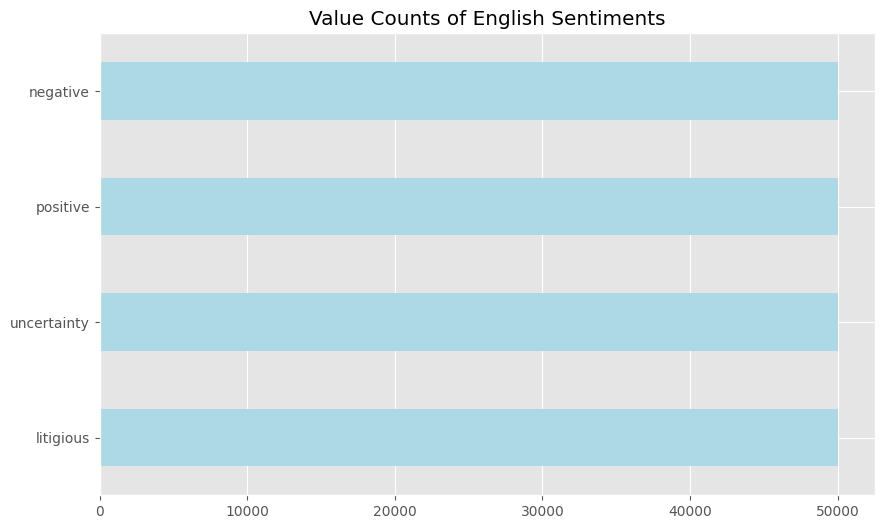

In [10]:
sentiments.plot(kind='barh', color='lightblue', figsize=(10,6))
plt.title('Value Counts of English Sentiments')
plt.show()

### Data Cleaning

1. Remove usernames from tweets
2. Remove hashtags from tweets
3. Remove things like http links and \n form tweet

##### Let's start with usernames

- We need to remove the usernames that follow the @ symbol. The symbol will be removed as well
- Write a function using the re module

In [11]:
# before
data['Text'][0]

'@Charlie_Corley @Kristine1G @amyklobuchar @StyleWriterNYC testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [12]:
def remove_usernames(text):
    pattern = r'@\w+\s?'
    result = re.sub(pattern, '', text)
    return result


data['Text'] = data['Text'].apply(remove_usernames)
data

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
14,"[When the first sign of surrender comes, Micha...",en,litigious
27,"""It's Your fight to save the UK from the liars...",en,litigious
...,...,...,...
191400,You agree it's a problem then?😆oh and pop your...,en,negative
191402,Having to carry/wear armor everywhere because ...,en,negative
191411,get lost This is not a trial it’s a sham just ...,en,negative
191413,Tacocat - The Internet - Lost Time (2016),en,negative


In [13]:
# after
data['Text'][0]

'testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [14]:
# corresponding label
data['Label'][0]

'litigious'

##### Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [15]:
# before
data['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n#SovereignGroup #SovereignAfrica #UNDP #Rwanda'

In [16]:
def remove_hastags(text):
    pattern = r'#\w+\s?'
    result = re.sub(pattern, '', text)
    return result


data['Text'] = data['Text'].apply(remove_hastags)
data

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
14,"[When the first sign of surrender comes, Micha...",en,litigious
27,"""It's Your fight to save the UK from the liars...",en,litigious
...,...,...,...
191400,You agree it's a problem then?😆oh and pop your...,en,negative
191402,Having to carry/wear armor everywhere because ...,en,negative
191411,get lost This is not a trial it’s a sham just ...,en,negative
191413,Tacocat - The Internet - Lost Time (2016),en,negative


#### Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [17]:
#after there are not more hashtags
data['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n'

##### Next, http links

- We need to remove all http links.
- Write a function using the re module

In [18]:
#before
data['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n'

In [19]:
def remove_urls(string):
    pattern = r'https?://\S+'
    result = re.sub(pattern, '', string)
    return result

data['Text'] = data['Text'].apply(remove_urls)

In [20]:
#after
data['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: \n\n'


##### Remove special characters

- We need to remove * and newline characters (\n).
- Write a function using the re module

In [21]:
#before
data['Text'].unique()

array(['testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination',
       ' Flagstar Bank discloses a data breach that impacted 1.5\nMillion individuals ',
       'OOPS. I typed her name incorrectly (today’s brave witness) . 6. 7. (probaby) . Don’t forget requesting a . ',
       ...,
       'get lost This is not a trial it’s a sham just like to President Joe Tarde ',
       'Tacocat - The Internet - Lost Time (2016)',
       "We'll discover the truth about what Gimmick REALLY thinks.\n\n🤥One Lie Detector Test\n🤥30+ Hard Hitting Questions\n🤥Heart Rate, Sweat Levels, Fidget Speeds\n\nDon't share with Gimmick. He doesn't know we're connecting him to this device. \n\nThe Truth Exposed on Thursday. "],
      dtype=object)

In [22]:
def remove_special_chars(text):
    pattern = r'[*\n]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

data['Text'] = data['Text'].apply(remove_special_chars)

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
2,Flagstar Bank discloses a data breach that im...,litigious
4,OOPS. I typed her name incorrectly (today’s br...,litigious
14,"[When the first sign of surrender comes, Micha...",litigious
27,"""It's Your fight to save the UK from the liars...",litigious
...,...,...
191400,You agree it's a problem then?😆oh and pop your...,negative
191402,Having to carry/wear armor everywhere because ...,negative
191411,get lost This is not a trial it’s a sham just ...,negative
191413,Tacocat - The Internet - Lost Time (2016),negative


# Let's Train a Bert Model with a quarter million Tweets

In [24]:
from torch.nn.utils.rnn import pad_sequence

#### Creating Tokenizer and Model

Let's convert our text and label column into list for easy splitting



In [25]:
X = data['Text'].to_list()
y = data['Label'].to_list()


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)



In [26]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training texts
train_encodings = tokenizer(X_train, truncation=True, padding=True)
train_labels = torch.tensor(train_labels)

In [27]:
# Tokenize and encode the test texts
test_encodings = tokenizer(X_test, truncation=True, padding=True)
test_labels = torch.tensor(label_encoder.transform(y_test))

In [28]:
# Create train and test datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [29]:

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [30]:
#Create train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [31]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [33]:
# Set training parameters
num_epochs = 2
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

In [ ]:
# Evaluation loop
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy().tolist())


In [ ]:
model

In [ ]:
tokenizer

In [ ]:
# Input text for prediction
input_text = "How are you?"

# Tokenize and encode the input text
input_encoding = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt')

# Make predictions
model.eval()
with torch.no_grad():
    input_ids = input_encoding['input_ids'].to(device)
    attention_mask = input_encoding['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_labels = logits.argmax(dim=1)

# Convert predicted labels back to original classes using label_encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels.cpu().numpy())

# Print the predicted class
print("Predicted class:", predicted_classes[0])
